# Условие задачи

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

# Задача

Построить модель, которая предскажет температуру стали во время последнего замера температуры, чтобы уменьшить потребление электроэнергии на этапе обработки стали


### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

# Примерный план решения задачи


    1) Загрузка данных, исследовательский анализ и первичная предобработка
    2) Подготовка данных:
        выделение признаков из каждой таблицы, необходимых для модели
        создание и добавление новых признаков
        удаление ненужных данных, если такие будут
    3) Сведение всех данных в единую таблицу с целевым признаком по "key"
    4) Выбор моделей для обучения, обучение модели с подбором параметров
    5) Сравнение результатов, выбор наилучшей модели
    6) Тестирование модели и проверка на адекватность
    7) Подготовка отчета

# 1) Загрузка данных, исследовательский анализ и первичная предобработка
Проведите исследовательский анализ данных. В конце Jupyter Notebook напишите:

    Список уточняющих вопросов.
    Примерный план решения задачи. Пропишите 3–5 основных шагов, каждый поясните не более двумя предложениями.

Ваши вопросы и план проверит тимлид. На эти вопросы он ответит во время созвона. К коду обратится, если только возникнут спорные моменты.

## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import math
import os
import re
import datetime
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold,train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
SEED=12345

In [2]:
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

In [3]:
#Функция для построения графиков
def draw(data, parametr, bins=30):
    fig = plt.figure(figsize=(15, 6), dpi= 80)
    grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)
    ax_main = fig.add_subplot(grid[:-1, :-1])
    ax_right = fig.add_subplot(grid[:-1, -1])  
    ax_main.hist(data[parametr], bins, histtype='stepfilled', orientation='vertical')
    ax_right.boxplot(data[parametr])
    ax_right.grid(axis='y')
    ax_main.set(title='Графики по '+parametr)
    plt.show()

## Данные об электродах (`data_arc.csv`)

In [4]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [5]:
data_arc.head(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


    пропусков нет
    признаки 'Начало нагрева дугой' и 'Конец нагрева дугой' приведем к типу datetime

In [6]:
data_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


Аномальное значение реактивной мощности = -715.504924

In [7]:
#Подсчитаем количество партий по количеству уникальных значений 'key'
len(data_arc['key'].unique())

3214

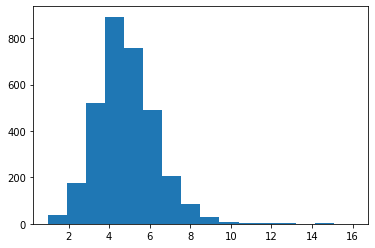

In [8]:
plt.hist((list(data_arc['key'].value_counts())), bins=16)
plt.show()

    Количество итераций обработки различается для каждой партии от 1 до 16. 
    Мода = 4

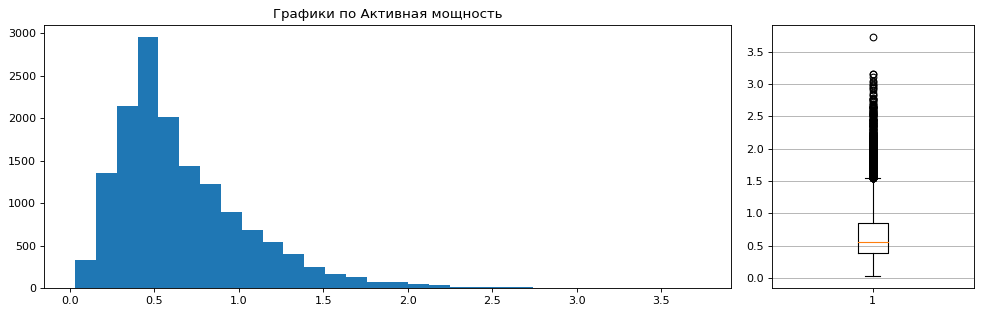

In [9]:
draw(data_arc, 'Активная мощность')

распределение напоминает нормальное со сдвигом влево

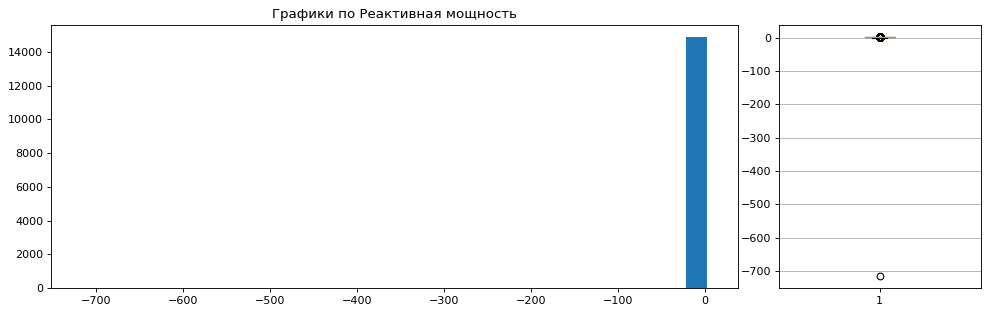

In [10]:
draw(data_arc, 'Реактивная мощность')

Аномальное значение реактивной мощности - ошибочное значение. Избавимся от него.

In [11]:
data_arc.loc[data_arc['Реактивная мощность'] < 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


In [12]:
data_arc = data_arc[data_arc['Реактивная мощность'] > 0]

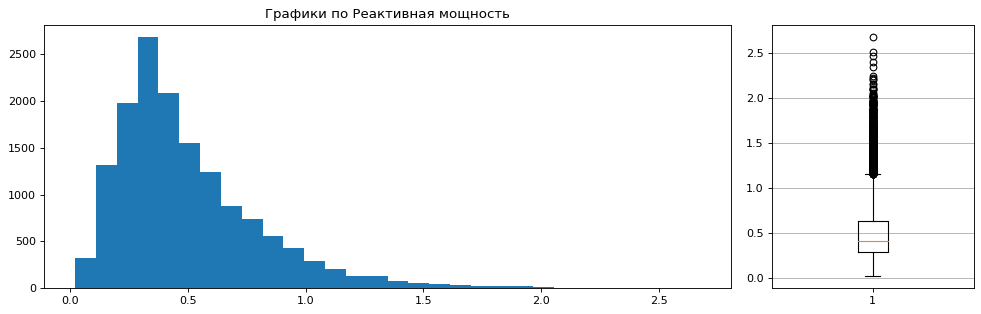

In [13]:
draw(data_arc, 'Реактивная мощность')

распределение напоминает нормальное со сдвигом влево

In [14]:
#Проведем заменту типа на datetime для 'Начало нагрева дугой' и Конец нагрева дугой'
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'],format='%Y-%m-%d %H:%M:%S')
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'],format='%Y-%m-%d %H:%M:%S')

In [15]:
data_arc.head(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


In [16]:
#проверим как соотносятся между собой параметры 'Активная мощность' и 'Реактивная мощность'
data_arc[['Активная мощность', 'Реактивная мощность']].corr()

,Активная мощность,Реактивная мощность
Активная мощность,1.000000,0.963182
Реактивная мощность,0.963182,1.000000


    'Активная мощность' и 'Реактивная мощность' значительно коррелируют между собой
    поэтому будем использовать новый параметр "Полную мощность", которая рассчитывается как 

$$ S=\sqrt{P^2+Q^2} $$

где:
    $P$ — активная мощность,
    $Q$ — реактивная мощность


In [17]:
def full_power(row):
    full_power = math.sqrt(row['Активная мощность']**2 + row['Реактивная мощность']**2)
    return full_power

In [18]:
data_arc['Полная мощность'] = data_arc.apply(full_power, axis=1)

In [19]:
data_arc.head(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1.193639
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.959010
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.896038
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1.970470
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.807239
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043,0.521549
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914,1.574162
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281,0.577638
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874,0.975867
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494,1.256527


## Итого:
В качестве признаков можно использовать для каждого key: 

    активную мощность
    реактивную мощность
    полную мощность
    длительность нагрева

## Данные о подаче сыпучих материалов (объём) (`data_bulk.csv`)

In [20]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Большое количество пропусков, есть столбцы, где почти все значения пропущены.

Это объясняется тем, что для каждой партии добавляют опредленное сочетание сыпучих материалов. 
Поэтому пропуски будем заполнять 0.

In [21]:
data_bulk.head(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


In [22]:
#Подсчитаем количество партий по количеству уникальных значений key
len(data_bulk['key'].unique())

3129

Каждой партии соответствует только одна строка.

In [23]:
keys = list(data_bulk['key'])
no_value = []
for i in list(range(1, 3242)):
    if i not in keys:
        no_value.append(i)
len(no_value)

112

Нет данных о 112 партиях

In [24]:
#Заполним пустые значения нулями
data_bulk = data_bulk.fillna(0)

In [25]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     3129 non-null float64
Bulk 2     3129 non-null float64
Bulk 3     3129 non-null float64
Bulk 4     3129 non-null float64
Bulk 5     3129 non-null float64
Bulk 6     3129 non-null float64
Bulk 7     3129 non-null float64
Bulk 8     3129 non-null float64
Bulk 9     3129 non-null float64
Bulk 10    3129 non-null float64
Bulk 11    3129 non-null float64
Bulk 12    3129 non-null float64
Bulk 13    3129 non-null float64
Bulk 14    3129 non-null float64
Bulk 15    3129 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [26]:
data_bulk.describe().sort_values('mean', axis = 1, ascending = False)

,key,Bulk 12,Bulk 14,Bulk 15,Bulk 3,Bulk 4,Bulk 6,Bulk 10,Bulk 11,Bulk 1,Bulk 5,Bulk 7,Bulk 2,Bulk 13,Bulk 9,Bulk 8
count,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000
mean,1624.383509,203.948226,152.706616,115.319271,47.240332,33.830617,21.892298,4.684564,4.345478,3.160435,2.633749,2.441675,1.779163,1.041866,0.463407,0.015660
std,933.337642,151.419639,81.091421,84.488698,74.239954,56.034505,55.492582,20.157323,22.699580,11.869164,20.918138,31.944063,21.217878,14.114252,6.154398,0.875978
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,816.000000,105.000000,104.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1622.000000,206.000000,148.000000,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2431.000000,263.000000,202.000000,204.000000,80.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3241.000000,1849.000000,636.000000,405.000000,454.000000,281.000000,503.000000,159.000000,313.000000,185.000000,603.000000,772.000000,325.000000,305.000000,147.000000,49.000000


По объему в среднем больше всего добавляют материалов 12, 14, 15; меньше всего - 13, 9, 8

## Итого:
В качестве признаков можно использовать для каждого key:

    объем по каждому добавленному материалу

## Данные о подаче сыпучих материалов (время) (`data_bulk_time.csv`)

In [27]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null object
Bulk 2     22 non-null object
Bulk 3     1298 non-null object
Bulk 4     1014 non-null object
Bulk 5     77 non-null object
Bulk 6     576 non-null object
Bulk 7     25 non-null object
Bulk 8     1 non-null object
Bulk 9     19 non-null object
Bulk 10    176 non-null object
Bulk 11    177 non-null object
Bulk 12    2450 non-null object
Bulk 13    18 non-null object
Bulk 14    2806 non-null object
Bulk 15    2248 non-null object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [28]:
data_bulk_time.head(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
5,6,NaN,NaN,NaN,2019-05-03 13:59:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:53:27,NaN,2019-05-03 13:53:27,2019-05-03 13:53:27
6,7,NaN,NaN,NaN,2019-05-03 14:29:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:22:19,NaN,2019-05-03 14:22:19,2019-05-03 14:22:19
7,8,NaN,NaN,NaN,2019-05-03 15:04:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:55:46,NaN,2019-05-03 14:55:46,2019-05-03 14:55:46
8,9,NaN,NaN,NaN,2019-05-03 15:47:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:41:00,NaN,2019-05-03 15:41:00,2019-05-03 15:41:00
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:18:52,NaN,2019-05-03 16:18:52,2019-05-03 16:18:52


In [29]:
#приведем данные к типу datetime
for i in range(1, 16):
    data_bulk_time[('Bulk %d'%i)] = pd.to_datetime(data_bulk_time[('Bulk %d'%i)] ,format='%Y-%m-%d %H:%M:%S')   

In [30]:
data_bulk_time.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null datetime64[ns]
Bulk 2     22 non-null datetime64[ns]
Bulk 3     1298 non-null datetime64[ns]
Bulk 4     1014 non-null datetime64[ns]
Bulk 5     77 non-null datetime64[ns]
Bulk 6     576 non-null datetime64[ns]
Bulk 7     25 non-null datetime64[ns]
Bulk 8     1 non-null datetime64[ns]
Bulk 9     19 non-null datetime64[ns]
Bulk 10    176 non-null datetime64[ns]
Bulk 11    177 non-null datetime64[ns]
Bulk 12    2450 non-null datetime64[ns]
Bulk 13    18 non-null datetime64[ns]
Bulk 14    2806 non-null datetime64[ns]
Bulk 15    2248 non-null datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


## Итого:
Таблица может служить для связи данных с другими таблицами через общий ключ - время.

## Данные о продувке сплава газом (`data_gas.csv`)

In [31]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Газ 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [32]:
data_gas.head(10)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


In [33]:
#Подсчитаем количество партий, количество уникальных значений параметра key
len(data_gas['key'].unique())

3239

Каждая партия в таблице встречается только 1 раз, значит это суммарная величина продува со всех этапов.

2 партии не продувались газом.

In [34]:
keys = list(data_gas['key'])
no_value_gas = []
for i in list(range(1, 3242)):
    if i not in keys:
        no_value_gas.append(i)
no_value_gas

[193, 259]

Отсутствуют данные для партий 193 и 259

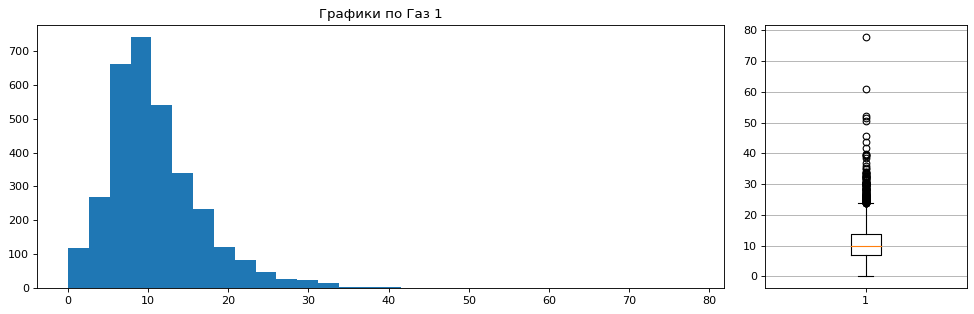

In [35]:
draw(data_gas, 'Газ 1')

распределение можно назвать нормальным сдвинутым влево, с пиком на 6-11

## Итого:
В качестве признаков можно использовать для каждого key:

    общий объем затраченного газа

## Результаты измерения температуры (`data_temp.csv`)

In [36]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null object
Температура     13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


    содержит 2901 пустых значений Температуры
    'Время замера' надо привести к типу datetime

In [37]:
data_temp.head(10)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


In [38]:
#количество партий по количество уникальных значений key
len(data_temp['key'].unique())

3216

Данные о температуре есть для 3216 партий

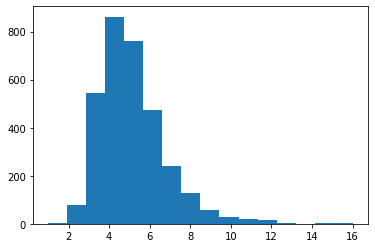

In [39]:
plt.hist((list(data_temp['key'].value_counts())), bins=16)
plt.show()

    Количество итераций варьируется для каждой партии от 1 до 16. 
    Мода = 4 итерации

In [40]:
data_temp.describe()

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


In [41]:
keys = list(data_temp['key'])
no_value_temp = []
for i in list(range(1, 3242)):
    if i not in keys:
        no_value_temp.append(i)
len(no_value_temp)

25

Отсутствуют данные для 25 партий

In [42]:
#параметр 'Время замера' приведем к типу datetime
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'],format='%Y-%m-%d %H:%M:%S')

In [43]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null datetime64[ns]
Температура     13006 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


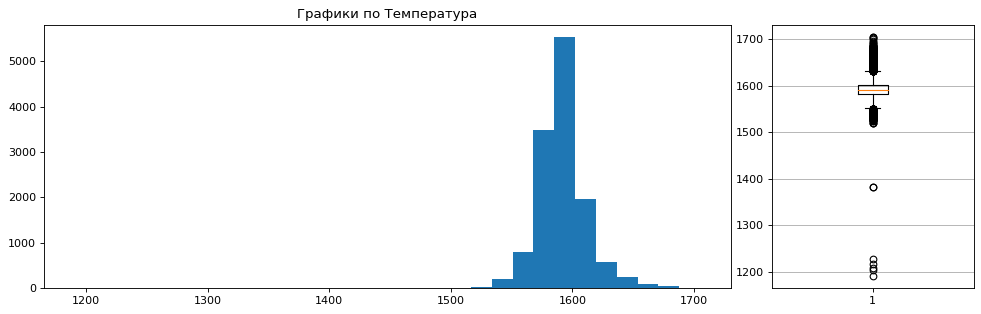

In [44]:
draw(data_temp.dropna(), 'Температура')

    Есть выбросы и пропуски, но от них не будем пока избавляться
    Время замера связывает таблицу с данными в других таблицах

In [45]:
data_temp['key'].value_counts()

44      16
1214    16
1513    16
46      16
1689    15
        ..
1106     2
1424     2
3156     2
279      1
195      1
Name: key, Length: 3216, dtype: int64

В двух партиях только одно измерение температуры, значит мы не сможем использовать эти данные. Потому что нам нужно минимум два значения - первое и последнее(для целевого признака)

In [46]:
#Удалим все данные с партиями 195 и 279
data_temp = data_temp.query('key not in (195, 279)')
data_gas = data_gas.query('key not in (195, 279)')
data_bulk = data_bulk.query('key not in (195, 279)')
data_wire = data_wire.query('key not in (195, 279)')

In [47]:
#посмотрим на пропуски Температура
data_temp[data_temp['Температура'].isnull()].head(10)

,key,Время замера,Температура
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN
12272,2501,2019-08-06 04:01:59,NaN
12273,2501,2019-08-06 04:14:35,NaN
12274,2501,2019-08-06 04:22:14,NaN
12275,2501,2019-08-06 04:31:14,NaN
12277,2502,2019-08-06 04:46:04,NaN
12278,2502,2019-08-06 04:52:32,NaN
12279,2502,2019-08-06 04:57:30,NaN


После 2500 партии есть только первое измерение температуры

## Итого:
Время первого и последнего замера помогут в отборе остальных признаков - чтобы взять только те данные, которые происходили во время между этими замерами. Перед обучением модели мы их удалим.

Псоле 2500 партии значения температуры есть только для первого измерения. Поэтому будем использовать только партии до 2500 номера.

В качестве признаков можно использовать для каждого key:

    результат первого измерения температуры
    длительность времени между первым и последним замерами
    общее количество замеров

Целевой признак - результат последнего измерения температуры

## Данные о проволочных материалах (объём) (`data_wire.csv`)


In [48]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3080 entries, 0 to 3080
Data columns (total 10 columns):
key       3080 non-null int64
Wire 1    3054 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 264.7 KB


In [49]:
data_wire.head(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
#посмотрим количество партий по количеству уникальных значений key
len(data_wire['key'].unique())

3080

Каждый ключ встречается только 1 раз

In [51]:
#заполним пропуски нулями
data_wire = data_wire.fillna(0)

In [52]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3080 entries, 0 to 3080
Data columns (total 10 columns):
key       3080 non-null int64
Wire 1    3080 non-null float64
Wire 2    3080 non-null float64
Wire 3    3080 non-null float64
Wire 4    3080 non-null float64
Wire 5    3080 non-null float64
Wire 6    3080 non-null float64
Wire 7    3080 non-null float64
Wire 8    3080 non-null float64
Wire 9    3080 non-null float64
dtypes: float64(9), int64(1)
memory usage: 264.7 KB


## Итого:
В разные партии добавляют разное количество материалов, разный их объем, поэтому пропуски заполнили нулями

В качестве признаков можно использовать для каждого key:

    объем по каждому добавленному материалу

## Данные о проволочных материалах (время) (`data_wire_time.csv`)

In [53]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null object
Wire 2    1079 non-null object
Wire 3    63 non-null object
Wire 4    14 non-null object
Wire 5    1 non-null object
Wire 6    73 non-null object
Wire 7    11 non-null object
Wire 8    19 non-null object
Wire 9    29 non-null object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [54]:
data_wire_time.head(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:59:02,2019-05-03 13:59:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:28:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:03:42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:42:43,2019-05-03 15:58:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:20:25,2019-05-03 16:21:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
#приведем данные к типу datetime
for i in range(1, 10):
    data_wire_time[('Wire %d'%i)] = pd.to_datetime(data_wire_time[('Wire %d'%i)] ,format='%Y-%m-%d %H:%M:%S')   

In [56]:
data_wire_time.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null datetime64[ns]
Wire 2    1079 non-null datetime64[ns]
Wire 3    63 non-null datetime64[ns]
Wire 4    14 non-null datetime64[ns]
Wire 5    1 non-null datetime64[ns]
Wire 6    73 non-null datetime64[ns]
Wire 7    11 non-null datetime64[ns]
Wire 8    19 non-null datetime64[ns]
Wire 9    29 non-null datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


## Итого:
Таблица может служить для связи данных с другими таблицами через общий ключ - время.

# 2) Подготовка данных

In [57]:
#Поcле 2500 партии значения температуры есть только для первого измерения. Поэтому будем использовать только партии до 2500 номера.
data_temp = data_temp.query('key < 2500')
data_arc = data_arc.query('key < 2500')
data_bulk = data_bulk.query('key < 2500')
data_wire = data_wire.query('key < 2500')

## data_temp

In [58]:
#Время последнего измерения для каждой партии
#Последнее значение температуры = data_temp.sort_values('Время замера').groupby('key').last()['Температура']
last_time_temp = pd.to_datetime(data_temp.groupby('key')['Время замера'].max())
#Время последнего измерения и значение температуры в каждой партии
temp_target = data_temp.merge(last_time_temp, on="Время замера").rename(columns={"Время замера": "Последнее время замера температуры", "Температура": "Последнее значение температуры"})

In [59]:
temp_target.head(10)

,key,Последнее время замера температуры,Последнее значение температуры
0,1,2019-05-03 11:30:39,1613.0
1,2,2019-05-03 11:59:12,1602.0
2,3,2019-05-03 12:34:57,1599.0
3,4,2019-05-03 12:59:25,1625.0
4,5,2019-05-03 13:36:01,1602.0
5,6,2019-05-03 14:12:29,1596.0
6,7,2019-05-03 14:42:37,1599.0
7,8,2019-05-03 15:22:52,1598.0
8,9,2019-05-03 16:01:16,1592.0
9,10,2019-05-03 16:36:08,1593.0


In [60]:
temp_target.shape

(2475, 3)

In [61]:
#Время первого измерения для каждой партии
first_time_temp = pd.to_datetime(data_temp.groupby('key')['Время замера'].min())
#Время первого измерения и значение температуры в каждой партии
temp_first = data_temp.merge(first_time_temp, on="Время замера").rename(columns={"Время замера": "Время первого замера температуры", "Температура": "Первое значение температуры"})

In [62]:
temp_first.head(10)

,key,Время первого замера температуры,Первое значение температуры
0,1,2019-05-03 11:16:18,1571.0
1,2,2019-05-03 11:37:27,1581.0
2,3,2019-05-03 12:13:17,1596.0
3,4,2019-05-03 12:52:57,1601.0
4,5,2019-05-03 13:23:19,1576.0
5,6,2019-05-03 13:49:24,1543.0
6,7,2019-05-03 14:19:43,1586.0
7,8,2019-05-03 15:07:18,1577.0
8,9,2019-05-03 15:37:03,1587.0
9,10,2019-05-03 16:14:29,1574.0


In [63]:
#Время между первым и последним замером
time_diff_temp = (pd.pivot_table(data_temp[['key', 'Время замера']], index='key',  aggfunc='max') - pd.pivot_table(data_temp[['key', 'Время замера']], index='key',  aggfunc='min'))/np.timedelta64(1, 's')
time_diff_temp.columns = ['Между первым и последним замером']
time_diff_temp.head()

,Между первым и последним замером
key,
1,861.0
2,1305.0
3,1300.0
4,388.0
5,762.0


In [64]:
time_diff_temp.shape

(2475, 1)

In [65]:
#Количество замеров Температуры
total_count_temp = pd.pivot_table(data_temp[['key', 'Температура']],index='key',  aggfunc='count')
total_count_temp.columns = ['Количество замеров']

In [66]:
total_count_temp.head()

,Количество замеров
key,
1,5
2,6
3,5
4,3
5,2


In [67]:
total_count_temp.shape

(2475, 1)

## data_arc

In [68]:
#Количество запусков нагрева в каждой партии
total_count_arc = data_arc['key'].value_counts().sort_index().reset_index().rename(columns={"index": "key", "key": "Количество запусков нагрева"})

In [69]:
total_count_arc.head(10)

,key,Количество запусков нагрева
0,1,5
1,2,4
2,3,5
3,4,4
4,5,4
5,6,4
6,7,4
7,8,4
8,9,5
9,10,6


In [70]:
total_count_arc.shape

(2475, 2)

In [71]:
#Сумма активных и реактивных мощностей в каждой партии
power_sum = data_arc.groupby('key')['Активная мощность', 'Реактивная мощность'].sum().reset_index().rename(columns={"Активная мощность": "Сумма активной мощности", "Реактивная мощность": "Сумма реактивной мощности"})

In [72]:
power_sum['Полная мощность'] = data_arc.apply(full_power, axis=1)

In [73]:
power_sum.head(10)

,key,Сумма активной мощности,Сумма реактивной мощности,Полная мощность
0,1,4.878147,3.183241,1.193639
1,2,3.052598,1.998112,0.959010
2,3,2.525882,1.599076,0.896038
3,4,3.209250,2.060298,1.970470
4,5,3.347173,2.252643,0.807239
5,6,3.955108,2.689175,0.521549
6,7,2.547375,1.561295,1.574162
7,8,3.762755,2.680698,0.577638
8,9,2.081951,1.478671,0.975867
9,10,2.923622,2.496116,1.256527


In [74]:
#Новый признак с длительностью нагрева для каждой итерации (сек)
data_arc['Длительность нагрева (сек)'] = (data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']) // pd.Timedelta('1s')

In [75]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность,Длительность нагрева (сек)
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1.193639,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.959010,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.896038,172
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1.970470,365
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.807239,148


In [76]:
#Группирую данные по значению key, суммирую значения длительности нагрева
arc_group = data_arc.groupby('key')['Длительность нагрева (сек)'].sum().reset_index()

In [77]:
arc_group.head(10)

,key,Длительность нагрева (сек)
0,1,1098
1,2,811
2,3,655
3,4,741
4,5,869
5,6,952
6,7,673
7,8,913
8,9,625
9,10,825


In [78]:
#Начало первого нагрева дугой и окончание последнего нагрева для каждой партии
start = pd.to_datetime(data_arc.groupby('key')['Начало нагрева дугой'].min()).reset_index()
stop = pd.to_datetime(data_arc.groupby('key')['Конец нагрева дугой'].max()).reset_index()

In [79]:
#Объединяю данные с признаками start и stop - значения начала первого нагрева дугой и окончания последнего нагрева
arc_group = arc_group.merge(start, on='key')
arc_group = arc_group.merge(stop, on='key')

In [80]:
#arc_group = arc_group.rename(columns={"Начало нагрева дугой": "start", "Конец нагрева дугой": "stop"})

In [81]:
arc_group.head(10)

,key,Длительность нагрева (сек),Начало нагрева дугой,Конец нагрева дугой
0,1,1098,2019-05-03 11:02:14,2019-05-03 11:28:37
1,2,811,2019-05-03 11:34:14,2019-05-03 11:53:18
2,3,655,2019-05-03 12:06:54,2019-05-03 12:32:19
3,4,741,2019-05-03 12:39:37,2019-05-03 12:57:50
4,5,869,2019-05-03 13:11:13,2019-05-03 13:33:55
5,6,952,2019-05-03 13:46:51,2019-05-03 14:09:24
6,7,673,2019-05-03 14:16:46,2019-05-03 14:41:15
7,8,913,2019-05-03 14:53:56,2019-05-03 15:14:47
8,9,625,2019-05-03 15:33:42,2019-05-03 15:59:48
9,10,825,2019-05-03 16:11:08,2019-05-03 16:34:50


In [82]:
arc_group.shape

(2475, 4)

# 3) Сведение всех данных в единую таблицу

In [83]:
data_final = data_gas.merge(temp_target, on='key')
#Добавляю данные с временем первого измерения и значениями температуры
data_final = data_final.merge(temp_first, on='key')
data_final = data_final.merge(time_diff_temp, on='key')
data_final = data_final.merge(total_count_temp, on='key')

In [84]:
data_final.head()

,key,Газ 1,Последнее время замера температуры,Последнее значение температуры,Время первого замера температуры,Первое значение температуры,Между первым и последним замером,Количество замеров
0,1,29.749986,2019-05-03 11:30:39,1613.0,2019-05-03 11:16:18,1571.0,861.0,5
1,2,12.555561,2019-05-03 11:59:12,1602.0,2019-05-03 11:37:27,1581.0,1305.0,6
2,3,28.554793,2019-05-03 12:34:57,1599.0,2019-05-03 12:13:17,1596.0,1300.0,5
3,4,18.841219,2019-05-03 12:59:25,1625.0,2019-05-03 12:52:57,1601.0,388.0,3
4,5,5.413692,2019-05-03 13:36:01,1602.0,2019-05-03 13:23:19,1576.0,762.0,2


In [85]:
#Добавляю данные с количеством итераций в каждой партии
data_final = data_final.merge(total_count_arc, on='key')
#Добавляю данные с суммарной активной и реактивной мощностями
data_final = data_final.merge(power_sum, on='key')
#Добавляю данные с временем начала первого нагрева дугой, окончанием последнего нагрева и общим временем нагрева для каждой партии
data_final = data_final.merge(arc_group, on='key')

In [86]:
#Создаю признаки с длительностью времени от начала нагрева дугой в секундах
data_final['delta1'] = (data_final['Время первого замера температуры'] - data_final['Начало нагрева дугой']) // pd.Timedelta('1s')
data_final['delta2'] = (data_final['Конец нагрева дугой'] - data_final['Начало нагрева дугой']) // pd.Timedelta('1s')
data_final['delta3'] = (data_final['Последнее время замера температуры'] - data_final['Начало нагрева дугой']) // pd.Timedelta('1s')

In [87]:
data_final.head()

,key,Газ 1,Последнее время замера температуры,Последнее значение температуры,Время первого замера температуры,Первое значение температуры,Между первым и последним замером,Количество замеров,Количество запусков нагрева,Сумма активной мощности,Сумма реактивной мощности,Полная мощность,Длительность нагрева (сек),Начало нагрева дугой,Конец нагрева дугой,delta1,delta2,delta3
0,1,29.749986,2019-05-03 11:30:39,1613.0,2019-05-03 11:16:18,1571.0,861.0,5,5,4.878147,3.183241,1.193639,1098,2019-05-03 11:02:14,2019-05-03 11:28:37,844,1583,1705
1,2,12.555561,2019-05-03 11:59:12,1602.0,2019-05-03 11:37:27,1581.0,1305.0,6,4,3.052598,1.998112,0.959010,811,2019-05-03 11:34:14,2019-05-03 11:53:18,193,1144,1498
2,3,28.554793,2019-05-03 12:34:57,1599.0,2019-05-03 12:13:17,1596.0,1300.0,5,5,2.525882,1.599076,0.896038,655,2019-05-03 12:06:54,2019-05-03 12:32:19,383,1525,1683
3,4,18.841219,2019-05-03 12:59:25,1625.0,2019-05-03 12:52:57,1601.0,388.0,3,4,3.209250,2.060298,1.970470,741,2019-05-03 12:39:37,2019-05-03 12:57:50,800,1093,1188
4,5,5.413692,2019-05-03 13:36:01,1602.0,2019-05-03 13:23:19,1576.0,762.0,2,4,3.347173,2.252643,0.807239,869,2019-05-03 13:11:13,2019-05-03 13:33:55,726,1362,1488


In [88]:
#Добавляю данные о подачи сыпучих материалов и проволоки
data_final = data_final.merge(data_bulk, on='key')
data_final = data_final.merge(data_wire, on='key')

In [89]:
data_final.head()

,key,Газ 1,Последнее время замера температуры,Последнее значение температуры,Время первого замера температуры,Первое значение температуры,Между первым и последним замером,Количество замеров,Количество запусков нагрева,Сумма активной мощности,...,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,29.749986,2019-05-03 11:30:39,1613.0,2019-05-03 11:16:18,1571.0,861.0,5,5,4.878147,...,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,12.555561,2019-05-03 11:59:12,1602.0,2019-05-03 11:37:27,1581.0,1305.0,6,4,3.052598,...,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,28.554793,2019-05-03 12:34:57,1599.0,2019-05-03 12:13:17,1596.0,1300.0,5,5,2.525882,...,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,18.841219,2019-05-03 12:59:25,1625.0,2019-05-03 12:52:57,1601.0,388.0,3,4,3.209250,...,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,5.413692,2019-05-03 13:36:01,1602.0,2019-05-03 13:23:19,1576.0,762.0,2,4,3.347173,...,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
#Удалим признаки со временем и key
data_final = data_final.drop(['key', 'Начало нагрева дугой', 'Конец нагрева дугой', 'Время первого замера температуры', 'Последнее время замера температуры'], axis=1)

In [91]:
data_final.shape

(2329, 37)

In [92]:
data_final.head()

,Газ 1,Последнее значение температуры,Первое значение температуры,Между первым и последним замером,Количество замеров,Количество запусков нагрева,Сумма активной мощности,Сумма реактивной мощности,Полная мощность,Длительность нагрева (сек),...,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,29.749986,1613.0,1571.0,861.0,5,5,4.878147,3.183241,1.193639,1098,...,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,12.555561,1602.0,1581.0,1305.0,6,4,3.052598,1.998112,0.959010,811,...,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,28.554793,1599.0,1596.0,1300.0,5,5,2.525882,1.599076,0.896038,655,...,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,18.841219,1625.0,1601.0,388.0,3,4,3.209250,2.060298,1.970470,741,...,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.413692,1602.0,1576.0,762.0,2,4,3.347173,2.252643,0.807239,869,...,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [93]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 37 columns):
Газ 1                               2329 non-null float64
Последнее значение температуры      2329 non-null float64
Первое значение температуры         2329 non-null float64
Между первым и последним замером    2329 non-null float64
Количество замеров                  2329 non-null int64
Количество запусков нагрева         2329 non-null int64
Сумма активной мощности             2329 non-null float64
Сумма реактивной мощности           2329 non-null float64
Полная мощность                     2329 non-null float64
Длительность нагрева (сек)          2329 non-null int64
delta1                              2329 non-null int64
delta2                              2329 non-null int64
delta3                              2329 non-null int64
Bulk 1                              2329 non-null float64
Bulk 2                              2329 non-null float64
Bulk 3                             

# 4) Обучение моделей

In [94]:
#Разделим данные на обучающую и тестовую выборки в соотношении 80/20
X = data_final.drop('Последнее значение температуры', axis=1)
y = data_final['Последнее значение температуры']

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=SEED)

In [96]:
#Проведем скалирование
sc = StandardScaler().fit(X_train)
X_train_scaled = sc.transform(X_train)
X_test_scaled = sc.transform(X_test)

In [97]:
#Подбор гиперпараметров с кросс-валидацией на 5 подвыборках
kf = KFold(n_splits=5, shuffle=False, random_state=SEED)

In [98]:
final_score = {}

### LinearRegression

In [99]:
lr_param = {'fit_intercept':[True,False], 
            'normalize':[True,False]}
gs_lr = GridSearchCV(LinearRegression(), lr_param, cv=kf, scoring='neg_mean_absolute_error')
gs_lr.fit(X_train_scaled, y_train)
params = gs_lr.best_params_
print('MAE на кросс-валидации: ', abs(gs_lr.best_score_))
lr = LinearRegression(**params)
lr.fit(X_train_scaled, y_train)
pred_test = lr.predict(X_test_scaled)
print(params)
print("MAE на тестовой выборке: ", mean_absolute_error(y_test, pred_test))

MAE на кросс-валидации:  9.888613887157915
{'fit_intercept': True, 'normalize': True}
MAE на тестовой выборке:  6.212405517796312


In [100]:
final_score['LinearRegression'] = [abs(gs_lr.best_score_), mean_absolute_error(y_test, pred_test), params]

### RandomForestRegressor

In [101]:
rfr_param = {'n_estimators': np.arange(300, 700, 100), 
            'max_depth': np.arange(3, 7),
            'min_samples_split': np.arange(2, 10, 2)}
gs_rfr = GridSearchCV(RandomForestRegressor(random_state=SEED), rfr_param, refit=False, cv=kf, scoring='neg_mean_absolute_error') 
gs_rfr.fit(X_train_scaled, y_train)
print('MAE на кросс-валидации: ', abs(gs_rfr.best_score_))
params = gs_rfr.best_params_
rfr = RandomForestRegressor(**params, random_state=SEED)
rfr.fit(X_train_scaled, y_train)
pred_test = rfr.predict(X_test_scaled)
print(params)
print("MAE на тестовой выборке: ", mean_absolute_error(y_test, pred_test))

MAE на кросс-валидации:  6.2269322349827805
{'max_depth': 6, 'min_samples_split': 2, 'n_estimators': 600}
MAE на тестовой выборке:  6.03547721866875


In [102]:
final_score['RandomForestRegressor'] = [abs(gs_rfr.best_score_), mean_absolute_error(y_test, pred_test), params]

### LGBMRegressor

In [103]:
lgbm_param = {'n_estimators': np.arange(300, 700, 100), 
              'learning_rate': np.arange(0.02, 0.12, 0.02),
              'max_depth': np.arange(3, 7)}
gs_lgbm = GridSearchCV(lgb.LGBMRegressor(random_state=SEED), lgbm_param, cv=kf, scoring='neg_mean_absolute_error', refit=False) 
gs_lgbm.fit(X_train_scaled, y_train)
print('MAE на кросс-валидации: ', abs(gs_lgbm.best_score_))
params = gs_lgbm.best_params_
lgbm = lgb.LGBMRegressor(**params, random_state=SEED)
lgbm.fit(X_train_scaled, y_train)
pred_test = lgbm.predict(X_test_scaled)
print(params)
print("MAE на тестовой выборке: ", mean_absolute_error(y_test, pred_test))

MAE на кросс-валидации:  5.714125835274192
{'learning_rate': 0.02, 'max_depth': 5, 'n_estimators': 600}
MAE на тестовой выборке:  5.418144521390794


In [104]:
final_score['LGBMRegressor'] = [abs(gs_lgbm.best_score_), mean_absolute_error(y_test, pred_test), params]

### CatBoostRegressor

In [105]:
ctb_param = {'n_estimators': np.arange(300, 700, 100),  
             'learning_rate': np.arange(0.02, 0.12, 0.02),
             'depth': np.arange(3, 7)}
gs_ctb = GridSearchCV(CatBoostRegressor(random_state=SEED, silent=True), ctb_param, cv=kf, scoring='neg_mean_absolute_error', refit=False) 
gs_ctb.fit(X_train_scaled, y_train)
print('MAE на кросс-валидации: ', abs(gs_ctb.best_score_))
params = gs_ctb.best_params_
ctb = CatBoostRegressor(**params, random_state=SEED, silent=True)
ctb.fit(X_train_scaled, y_train)
pred_test = ctb.predict(X_test_scaled)
print(params)
print("MAE на тестовой выборке: ", mean_absolute_error(y_test, pred_test))

MAE на кросс-валидации:  5.538401587253201
{'depth': 3, 'learning_rate': 0.08, 'n_estimators': 600}
MAE на тестовой выборке:  5.256536697528179


In [106]:
final_score['CatBoostRegressor'] = [abs(gs_ctb.best_score_), mean_absolute_error(y_test, pred_test), params]

# 5) Сравнение результатов, выбор наилучшей модели

,MAE на кросс-валидации,MAE на тестовой выборке,Лучшие параметры
LinearRegression,9.888614,6.212406,"{'fit_intercept': True, 'normalize': True}"
RandomForestRegressor,6.226932,6.035477,"{'max_depth': 6, 'min_samples_split': 2, 'n_es..."
LGBMRegressor,5.714126,5.418145,"{'learning_rate': 0.02, 'max_depth': 5, 'n_est..."
CatBoostRegressor,5.538402,5.256537,"{'depth': 3, 'learning_rate': 0.08, 'n_estimat..."


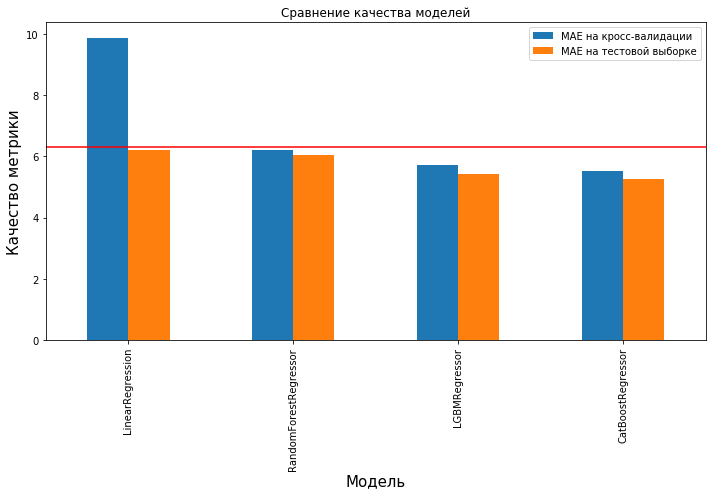

In [110]:
#Анализ результатови сравнение моделей 
data_final_score = pd.DataFrame.from_dict(data=final_score, columns=['MAE на кросс-валидации', 'MAE на тестовой выборке', 'Лучшие параметры'], orient='index')
display(data_final_score)

plt.figure(figsize=(10, 7))
plt.subplot(111)
data_final_score.plot(kind='bar', ax=plt.gca()).hlines(6.3, -1, 5, color = 'r')
plt.xlabel('Модель', fontsize=15)
plt.ylabel('Качество метрики', fontsize=15)
plt.title('Сравнение качества моделей')

plt.tight_layout()

Все модели показали хорошие результаты. Победила модель CatBoostRegressor с параметрами {'depth': 3, 'learning_rate': 0.08, 'n_estimators': 600}, которая показала MAE = 5.256537

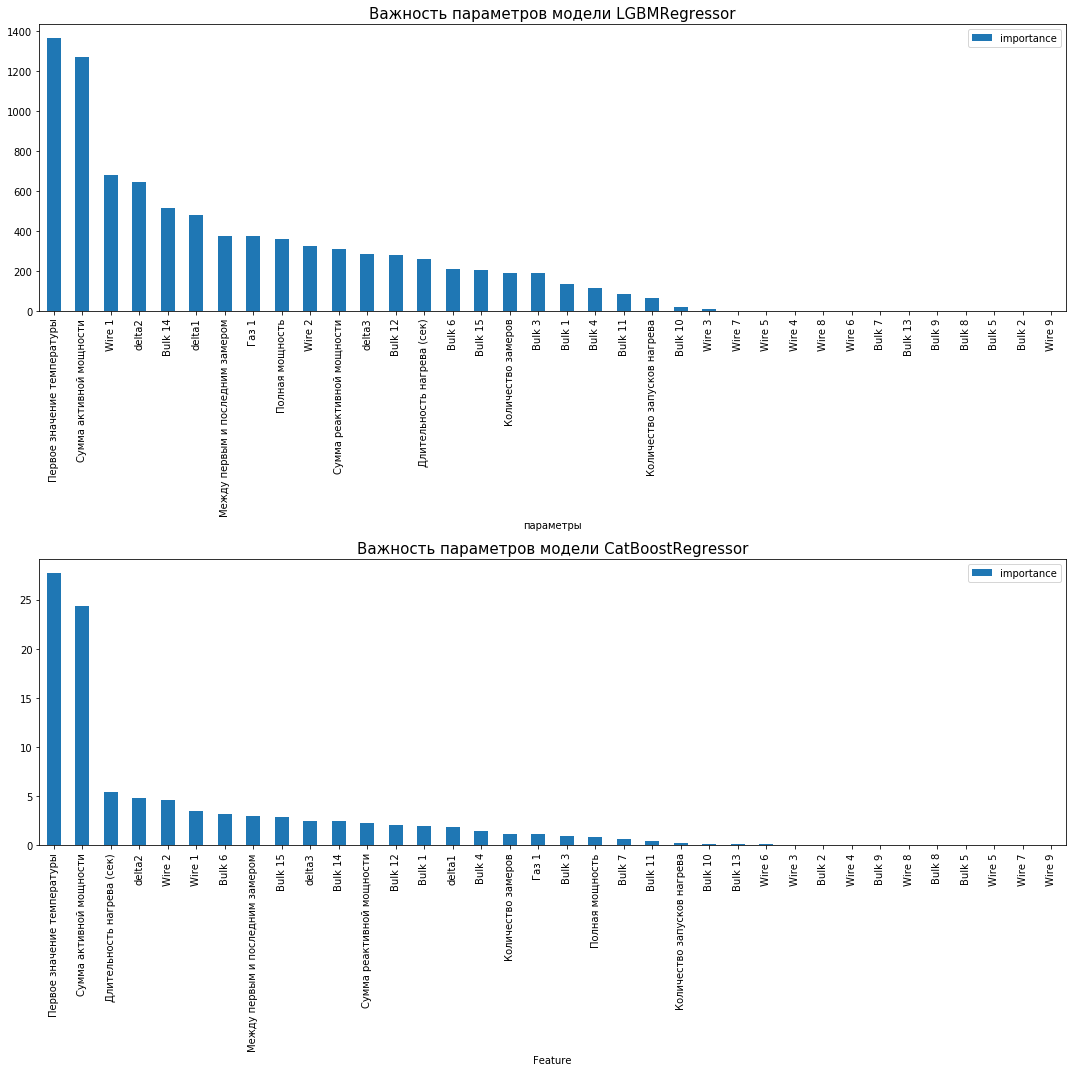

In [117]:
#посмотрим важность параметров моделей
importance_lgbm = (pd.DataFrame({'feature': X_train.columns, 'importance': lgbm.fit(X_train_scaled, y_train).feature_importances_}).sort_values(by='importance', ascending=False).reset_index())
importance_ctb = (pd.DataFrame({'feature': X_train.columns, 'importance': ctb.fit(X_train_scaled, y_train).feature_importances_}).sort_values(by='importance', ascending=False).reset_index())
plt.figure(figsize=(15, 15))
plt.subplot(211)           
importance_lgbm.plot(kind = 'bar', x='feature', y='importance', ax=plt.gca(), sharex=False)
plt.xlabel('параметры')
plt.title('Важность параметров модели LGBMRegressor', fontsize=15)
plt.subplot(212)    
importance_ctb.plot(kind = 'bar', x='feature', y='importance', ax=plt.gca(), sharex=False)
plt.xlabel('параметры')
plt.title('Важность параметров модели CatBoostRegressor', fontsize=15)
plt.tight_layout()

Для лучших моделей CatBoostRegressor и LGBMRegressor важность признаков расположена в разном порядке, но "Первое значение температуры" и "Сумма активной мощности" наиболее важны в обоих моделях.

## Выводы:


    При предобработке данных были удалены отрицательные значения реактивной мощности, данные с партиями 195 и 279. 
    Для обучения и тестирования моделей использовались данные партий до номера 2500. 
    В данных о подаче сыпучих материалов и проволоки пропуски были заполнены нулями.
    На тестовой выборке лучший результат MAE у модели CatBoostRegressor 5.256537, чуть хуже у модели LGBMRegressor - 5.418145, RandomForestRegressor показала MAE = 6.035477 и LinearRegression показала MAE = 6.212406
    Гиперпараметры лучшей модели CatBoostRegressor - {'depth': 3, 'learning_rate': 0.08, 'n_estimators': 600}


# 6) Тестирование модели и проверка на адекватность

In [120]:
#Рассчитаем метрику MAE для константной модели, в качестве предсказания возьмем среднее значение финальной температуры для обучающего набора данных.
mean_temp = pd.Series(y_train.mean(), index=y_test.index)
print("MAE константной модели: ", mean_absolute_error(y_test, mean_temp))

MAE константной модели:  8.432414376184962


Наша модель предсказывает лучше, чем константная

# 7) Отчет

Ответы на вопросы:

1. Какие пункты плана были выполнены, а какие — нет (поясните почему)?

Все пункты плана были выполнены. Сделано даже больше, чем планировалось. При составлении плана был уже сделан исследовательский анализ, но всего конечно же предусмотреть не получилось.

2. Какие трудности возникли и как вы их преодолели?

Были сложности при погружении в технологический процесс, когда нужно выстроить полную картину о происходящем, чтобы данные представляли собой не просто цифры. Было сложно делать проект с временными перерывами, когда тратилось время на погружение и вспоминание.

Скорее всего, поэтому и забыл я исключить Активную и Реактивную мощность из обучения, хотя при исследовании заметил их коллениарность и планировал заменить их на Полную мощность. Думаю, что это сделало бы модель еще лучше.

Для итоговой таблицы вел отдельный документ-шпаргалку, в котором фиксировал признаки, связи и таблицы.

Думаю, возможно, надо было бы сразу объединить все таблицы и провести анализ данных в ней. Думаю, было бы видно больше связей в данных и процессах, хотя конечно это бы усложнило работу. 

Еще надо было бы хотя бы формально проверить данные на дубли и сделать более подробный анализ корреляции признаков (как и писал ревьювер) непосредственно в итоговой таблице.

3. Какие ключевые шаги в решении задачи выделили?

- Исследовательсткий анализ и предобработка данных.
- Выделение признаков и объединение в итоговую таблицу.
- Обучение моделей и анализ результатов

4. Какая ваша итоговая модель и какое у неё качество?

На тестовой выборке лучший результат MAE у модели CatBoostRegressor 5.256537 с параметрами: {'depth': 3, 'learning_rate': 0.08, 'n_estimators': 600}

## Итоговые выводы:

При предобработке данных были удалены отрицательные значения реактивной мощности, данные с партиями 195 и 279. 

Для обучения и тестирования моделей использовались данные партий до номера 2500, т.к. поcле 2500 партии значения температуры есть только для первого измерения.

В данных о подаче сыпучих материалов и проволоки пропуски были заполнены нулями.

Финальный датасет состоит из 37 признаков и 2329 строк.

Целевой признак - последняя измеренная температура в партии.

Обучающая и тестовая выборка были разделены в соотношении 80/20.

Выбросы, кроме одного явно ошибочного значения реактивной мощности не удалялись. Предполагается, что отклоняющиеся значения обусловлены технологическим процессом, а не ошибками измерений.

Данные таблиц bulk и wire не имеют прямой корреляции с финальной температурой, но использовались в финальном датасете для обучения.

Было обучено 4 модели. На тестовой выборке лучший результат MAE показала модель CatBoostRegressor = 5.256537, чуть хуже у модели LGBMRegressor = 5.418145, RandomForestRegressor показала MAE = 6.035477 и LinearRegression показала MAE = 6.212406

Гиперпараметры лучшей модели CatBoostRegressor - {'depth': 3, 'learning_rate': 0.08, 'n_estimators': 600}

Для лучших моделей CatBoostRegressor и LGBMRegressor больше всего на предсказание финальной температуры влияют "Первое значение температуры" и "Сумма активной мощности".
